# Create NWM Benchmark

Notebook 3a/X

This notebook was written by Logan Qualls. Data for this work is sourced from the National Center for Atmospheric Research's Catchment Attributes and Meterology for Large-Sample Studies (CAMELS) dataset, and this notebook is designed to work specifically with Frederik Kratzert's NeuralHydrology (NH; https://github.com/neuralhydrology/neuralhydrology) and Grey Nearing's SACSMA-SNOW17 (SAC-SMA; https://github.com/Upstream-Tech/SACSMA-SNOW17). NH provides a flexible framework with a variety of tools specifically designed for straightforward application of Long Short-Term Memory networks to hydrological modeling. The SACSMA-SNOW17 model provides a Python interface for the SAC-SMA model.

As mentioned in notebook 2/X, using the NWM run as a benchmark may provide insight into the comparative predictive ability and degredation of NH and SAC-SMA models. If we specified that we only wanted to run experiments on data from years also avaliable for the NWM, this is where that benchmark materializes.

This notebook contains modified code from notebook 3a to calculate the NWM benchmark test metrics. **A more detailed walkthrough of this process is documented there.**

### Import Libraries

In [1]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from functions.functions import *

### Define Parameters

##### Paths

In [2]:
#########################################################################################

#Path to working directory (current directory)
working_dir = Path(os.getcwd())

#Path to main CAMELS directory (../camels)
camels_dir = working_dir / 'camels'

#Path to notebook_env_saves directory (.../notebook_env_saves)
env_saves_dir = working_dir / 'notebook_env_saves'

#Path to extreme dates directory (../train_test_sets)
dates_dir = working_dir / 'config_complementaries/train_test_sets'

#Path to daily nwm simulations (.../nwm_daily.pkl)
nwm_streamflow = working_dir / 'config_complementaries/nwm/nwm_daily.pkl'

#Path to file relating nwm keys to camels ids (.../camels_id.npy)
nwm_camels_ids = working_dir / 'config_complementaries/nwm/camels_id.npy'

#Path to CAMELS attributes, version 2 file (.../camels_attributes_v2.0.csv)
camels_attributes_dir  = camels_dir / 'camels_attributes_v2.0/camels_attributes_v2.0.csv'

#########################################################################################

##### Notebook Configurations

In [3]:
#########################################################################################

#Do we want to overwrite nwm files if they already exist?
overwrite = False

#Plot all metrics or only NSE?
plot_all_metrics = False

#########################################################################################

You should not have to edit anything below this.

In [4]:
#########################################################################################

env_saves = os.listdir(env_saves_dir)

#########################################################################################

#Define avaliable metric functions and extract the names of those functions
metrics = [alpha_nse,beta_kge,beta_nse,kge,mse,nse,rmse,pearsonr]
#Get names of avaliable metric functions
metrics_names = [x.__name__ for x in metrics]
#Set corresponding metric plot lims
axes = [(0,2,0,1),(0,3,0,1),(-1,1,0,1),(-20,1,0,1),(0,35,0,1),(-1,1,0,1),(0,5,0,1),(-0,1,0,1)]
#Create dictionary for metrics and axes
metric_axes_dict = {m:a for (m,a) in zip(metrics_names, axes)}

#Define metrics to plot and associated axes
if plot_all_metrics:
    
    plot_metrics = metrics_names
    
else:
    
    plot_metrics = ['nse']
    
#########################################################################################

### Load Source Data

Here we load in the supplemental CAMELS attributes file. This will be useful for several reasons; in this case, we need to extract basin information to convert NWM streamflow (m3/s) to mm to match model simulations.

In [5]:
#Load CAMELS attributes file with basin id as index
attributes = pd.read_csv(camels_attributes_dir, sep=';', index_col='gauge_id')

#Load usgs data
with open(env_saves_dir / f'usgs_runoff_data.pkl', 'rb') as f:
    usgs = pkl.load(f)
    
#Load the NWM identification key (basins labeled differently between CAMELS and NWM)
with open(nwm_camels_ids,'rb') as f:
    camels_nwm_basins = np.load(f)
        
#Load the streamflow simulations from the nwm run
with open(nwm_streamflow,'rb') as f:
    nwm = pkl.load(f)

##### Load test/start end dates

Because the NWM only uses NLDAS forcing data and does not has trained on only a subset of the years avaliable in CAMELS, we need to get a list of the files that only use NLDAS and that have only trained on "nwm" years.

Then, we need to load in the appropriate test dates files to calculate test metrics like we did for NH and SAC-SMA runs in notebook 4/X. From loading this in, we can also get information about experiment types and the respective basin list.

In [6]:
#Retreive list of files avaliable in env_saves_dir
date_files = [x for x in os.listdir(dates_dir) if 'nh_test' in x and 'nwm' in x and 'daymet' not in x]

#Initiate dictionary to store all loaded cdfs files
test_dates_dict = {}

exp_types = []

#For every file in cdfs_list...
for date in date_files:

    #Define path to the file
    path = dates_dir / date
    
    name = str(date.split('_')[2]) + '_' + str(date.split('_nwm_')[-1].split('.')[0])
    
    exp_type,experiment = name.split('_',1)
    
    if exp_type not in exp_types:
        
        exp_types.append(exp_type)
        
    #Open path...
    with open(path,'rb') as f:
        #...and load
        test_dates_dict[experiment] = pkl.load(f)
        
experiments = list(test_dates_dict.keys())
basins = list(test_dates_dict[experiments[0]].keys())

##### Create test year ranges from start/end dates

In [7]:
#Initialize dictionary containing date ranges sourced from start/end date values from test_dates_dict
test_years_dict = {}

#For every experiment...
for experiment in experiments:
    
    #Initialize experiment level
    test_years_dict[experiment] = {}
    
    #For every basin...
    for basin in test_dates_dict[experiment].keys():
        
        #Initialize throwaway list to contain date ranges
        all_dates = []
        
        #Define which experiment/basin we are looking at
        loc_in_dict = test_dates_dict[experiment][basin]
        
        #For every start/end date pair...
        for start,end in zip(loc_in_dict['start_dates'],loc_in_dict['end_dates']):
            
            #Create date range starting with start date and ending with end date
            dates = pd.date_range(start,end,freq='D')
            #Append those to all_dates
            all_dates.append(dates)
            
        #Save all of those dates to test_years_dict
        test_years_dict[experiment][basin] = pd.DatetimeIndex(np.unique(np.hstack(all_dates)))

##### Relate CAMELS IDs to NWM Keys

The basins used for NWM calibration extend far beyond the basins found in the CAMELS dataset and are also identified using different schemes. Here, we make the connection between the data using the NWM keys (keys_ids_df) and reindex them using the CAMELS IDs (nwm_fixed) so we can relate them to our climate experiment runs.

In [8]:
#Initiate dictionaries
keys_ids_df = pd.DataFrame()
keys_ids_df['nwm_keys'] = nwm.keys()
keys_ids_df['camels_id'] = camels_nwm_basins 
nwm_fixed = {experiment: {} for experiment in experiments}

#For every experiment...
for experiment in experiments:
    
    #And for every nwm key, camels id pair
    for key,basin in zip(keys_ids_df['nwm_keys'],keys_ids_df['camels_id']):

        #Load simulations for a basin into a basin's dataframe
        nwm_fixed[experiment][basin] = nwm[key]

##### Convert and scale simulations

Now that we have made the connection between NWM keys and replaced them with CAMELS IDs, we need to scale the NWM simulations to match the USGS observed streamflow data. For this we need to define several conversion factors.

In [9]:
#Retrieve area index information from attributes for conversion
area_index='area_geospa_fabric'

#Define conversion values
#Seconds in a day
sid = 60*60*24
#Meters in a kilometer
mikm = 0.001
#Millimeters in a meter
mmim = 0.001

Now we take the data from nwm_fixed and covert and save it into nwm_scaled.

In [10]:
#Create dictionary to contain converted streamflow values
nwm_scaled = {}

for experiment in experiments:
    
    nwm_scaled[experiment] = {}
    
    #For every basin...
    for i, basin in enumerate(basins):  
        
        basin = int(basin)

        #Create a dictionary entry for a basin
        nwm_scaled[experiment][basin] = []
        #Retreive area index attribute for a basin
        A = attributes.loc[basin, area_index]
        #Create conversion factor using conversion values defined above
        conversion_factor = sid * mmim / A
        #Multiply conversion factor by nwm simulation values and save into nwm_scaled
        nwm_scaled[experiment][basin] = conversion_factor * nwm_fixed[experiment][basin]['NWM_RUN']

### Calculate Metrics

Now we want to calculate metrics for the NWM run.

In [11]:
#Create a dictionary to contain metrics for each experiment type (extreme/random)
exp_type_metrics_dict = {exp_type: {} for exp_type in exp_types}

#For every experiment
for experiment in experiments:

    #If it is an extreme experiment...
    if 'high' in experiment or 'low' in experiment:

        #Set experiment type to extreme to key into exp_type_metrics_dict
        exp_type = 'extreme'

    #If its a random experiment...
    else:
        
        #Set experiment type to random
        exp_type = 'random'
    
    #If the nwm benchmark metrics file does not already exist OR we want to overwrite it...
    if not os.path.exists(env_saves_dir / f'basin_metrics_nwm_{exp_type}_nldas_extended_nwm.pkl') or overwrite == True:

        #Create dataframe for an experiment
        exp_type_metrics_dict[exp_type][experiment] = pd.DataFrame(index=basins,columns=metrics_names)

        print(f'Calculating metrics for {experiment}...')

        #For every metric to be calculated...
        for name,func in zip(tqdm(metrics_names),metrics):

            #For every basin...
            for basin in basins:

                #Create a list of test dates stacked into one datetime index
                mask = test_years_dict[experiment][basin]

                #Get observed values for the dates in the mask
                obs = usgs[basin].loc[mask]

                #Get simualted values for the dates in the mask
                sim = nwm_scaled[experiment][int(basin)].loc[mask].clip(0)

                #Calculate metrics between observed and simulated streamflow values
                exp_type_metrics_dict[exp_type][experiment][name].loc[basin] = func(obs,sim)


In [12]:
#For each experiment type (random/extreme)
for exp_type in exp_types:
    
    #If the nwm basin metrics file doesn't exist or we want to overwrite it...
    if not os.path.exists(env_saves_dir / f'basin_metrics_nwm_{exp_type}_nldas_extended_nwm.pkl') or overwrite == True:
    
        #Save metrics_dict
        with open(env_saves_dir / f'basin_metrics_nwm_{exp_type}_nldas_extended_nwm.pkl', 'wb') as f:
            pkl.dump(exp_type_metrics_dict[exp_type], f)

    #If the file already exists and we don't want to overwrite it...
    else:

        #Load nwm metrics dict
        with open(env_saves_dir / f'basin_metrics_nwm_{exp_type}_nldas_extended_nwm.pkl', 'rb') as f:
            exp_type_metrics_dict[exp_type] = pkl.load(f) 


##### Create CDF dictionary

In [13]:
#Initiate cdf dictionary
cdfs = {exp_type: {} for exp_type in exp_types}

#For every experiment
for experiment in experiments:
    
    #If it is an extreme experiment...
    if 'high' in experiment or 'low' in experiment:
        
        #Set experiment type to extreme to key into exp_type_metrics_dict
        exp_type = 'extreme'

    else:

        exp_type = 'random'
        
    
    #If the nwm cdfs dict file does not already exist OR we want to overwrite it...
    if not os.path.exists(env_saves_dir / f'cdfs_nwm_{exp_type}_nldas_extended_nwm.pkl') or overwrite == True:
 
        #Create dataframe for an experiment
        cdfs[exp_type][experiment] = {}
        
        #And for every metric...
        for metric in metrics_names:

            #Create a sub-dict for that metric
            cdfs[exp_type][experiment][metric] = {}

            #Sort the metric values in increasing order
            x = np.sort(exp_type_metrics_dict[exp_type][experiment][metric].dropna(axis=0))
            #Create range based on length of x
            y = np.arange(len(x))/(float(len(x)))
            #Make y a list
            y = y.tolist()

            #Initialize metric levl
            cdfs[exp_type][experiment][metric] = {}

            #Save x and y lists in cdfs dictionary
            cdfs[exp_type][experiment][metric]['x'] = x
            cdfs[exp_type][experiment][metric]['y'] = y

In [14]:
#For each experiment type (random/extreme)
for exp_type in exp_types:
    
    #If the nwm cdfs dict file does not already exist OR we want to overwrite it...
    if not os.path.exists(env_saves_dir / f'cdfs_nwm_{exp_type}_nldas_extended_nwm.pkl') or overwrite == True:
    
        #Save metrics_dict
        with open(env_saves_dir / f'cdfs_nwm_{exp_type}_nldas_extended_nwm.pkl', 'wb') as f:
            pkl.dump(cdfs[exp_type], f)

    #If the file already exists and we don't want to overwrite it...
    else:

        #Load metrics dict
        with open(env_saves_dir / f'cdfs_nwm_{exp_type}_nldas_extended_nwm.pkl', 'rb') as f:
            cdfs[exp_type] = pkl.load(f) 
            

##### Plot metric CDFs

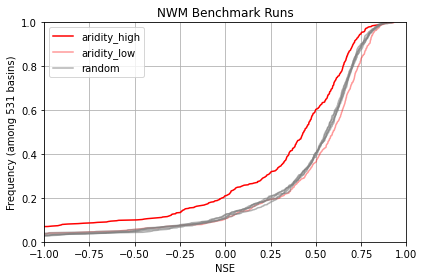

In [15]:
#Set r to 0 to keep count of how many random lines we are plotting
r = 0

#For every experiment...
for experiment in experiments:
    
    #For every metric...
    for metric in plot_metrics:
        
        ax = metric_axes_dict[metric]

        #If experiment type is extreme...
        if 'high' in experiment or 'low' in experiment:

            #Set exp_type to extreme
            exp_type = 'extreme'
            
            #Retrieve x and y from cdfs dict
            x = cdfs[exp_type][experiment][metric]['x']
            y = cdfs[exp_type][experiment][metric]['y']

            #Set default color and alpha
            c = 'r'
            alpha = 1

            #If it was a 'low' experiment...
            if 'low' in experiment:

                #Decrease the alpha to make it a lighter color
                alpha = 0.4
                
            #Plot extreme cdf line
            plt.plot(x,y,c=c,alpha=alpha,label=experiment)

        #If experiment type is not extreme...
        else:

            #Set exp_type to random
            exp_type = 'random'
            
            #Retrieve x and y from cdfs dict
            x = cdfs[exp_type][experiment][metric]['x']
            y = cdfs[exp_type][experiment][metric]['y']

            #Add 1 to r variable, make line grey, line width 1, and decrease alpha
            r = r + 1
            c = 'grey'
            alpha = 0.6

            if r == 1:
                
                #Plot random cdf line with label
                plt.plot(x,y,c=c,alpha=alpha,label='random')

            else:
                #Plot random cdf line with no label
                plt.plot(x,y,c=c,alpha=alpha)

#Plot grid
plt.grid()
#Show legend
plt.legend()
#Set axis
plt.axis(ax)
#Set title
plt.title('NWM Benchmark Runs')
#Set x label
plt.xlabel(f'{metric.upper()}')
#Set y label
plt.ylabel('Frequency (among 531 basins)')

#Show plot
plt.tight_layout()

Now we have NWM benchmark runs we can plot with the rest of our climate experiments.

**REMINDER:** This notebook contains modified code from notebook 3a to calculate the NWM benchmark test metrics. **A more detailed walkthrough of this process is documented there.**